In [1]:
import numpy as np
from microsim import schema as ms

def create_custom_channel(
    min_wave: int = 300, 
    max_wave: int = 800,
) -> ms.optical_config.OpticalConfig:

    custom_spectrum = ms.Spectrum(
        wavelength=np.arange(min_wave, max_wave, 1),
        intensity=np.ones(max_wave - min_wave),
    )

    custom_filter = ms.optical_config.SpectrumFilter(transmission=custom_spectrum) # placement=ALL by default

    custom_channel = ms.optical_config.OpticalConfig(
        name="FEDERICO",
        filters=[custom_filter],
    )
    
    return custom_channel

In [3]:
from microsim import schema as ms
import matplotlib.pyplot as plt

ROOT_DIR = "/group/jug/federico/careamics_training/data/BioSR"

custom_cache_settings = ms.settings.CacheSettings(
    read=False,
    write=False,
)

sim = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(1, 1004, 1004), scale=(0.02, 0.02, 0.02)),
    output_space={"downscale": (1, 4, 4)},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.BioSR(root_dir=ROOT_DIR, label="Microtubules"),
                fluorophore="mTurquoise",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.BioSR(root_dir=ROOT_DIR, label="ER"),
                fluorophore="EGFP",
            ),
            ms.FluorophoreDistribution(
                distribution=ms.BioSR(root_dir=ROOT_DIR, label="F-actin"),
                fluorophore="EYFP",
            )
        ]
    ),
    channels= [create_custom_channel(min_wave=460, max_wave=550)],
    modality=ms.Confocal(pinhole_au=2),
    settings=ms.Settings(random_seed=100, max_psf_radius_aus=2, cache=custom_cache_settings),
    detector=ms.CameraCCD(qe=0.5, read_noise=6, bit_depth=12),
    emission_bins=32,
    light_powers=[3, 1, 1]
)

(3, 1, 1004, 1004) Coordinates:
  * z        (z) float64 8B 0.0
  * y        (y) float64 8kB 0.0 0.02 0.04 0.06 0.08 ... 20.0 20.02 20.04 20.06
  * x        (x) float64 8kB 0.0 0.02 0.04 0.06 0.08 ... 20.0 20.02 20.04 20.06
  * f        (f) object 24B distribution=BioSR(root_dir='/group/jug/federico/...


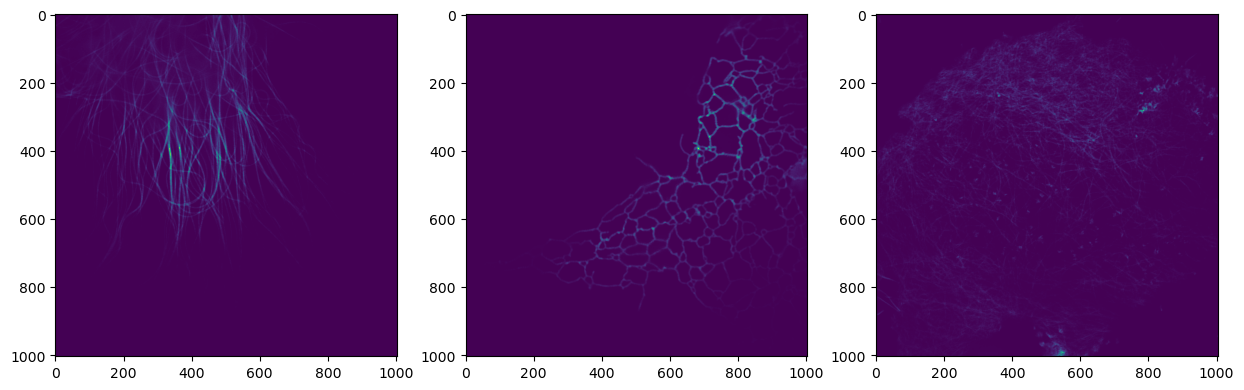

In [7]:
gt = sim.ground_truth()
print(gt.sizes) # (F, Z, Y, X)

_, ax = plt.subplots(1, gt.shape[0], figsize=(15, 5))
for i in range(gt.shape[0]):
    ax[i].imshow(gt[i, 0, ...])

(32, 1, 4, 1, 1004, 1004) Coordinates:
  * z        (z) float64 8B 0.0
  * y        (y) float64 8kB 0.0 0.02 0.04 0.06 0.08 ... 20.0 20.02 20.04 20.06
  * x        (x) float64 8kB 0.0 0.02 0.04 0.06 0.08 ... 20.0 20.02 20.04 20.06
  * f        (f) object 32B distribution=BioSR(root_dir='/group/jug/federico/...
  * w        (w) object 256B (460.0, 463.0] (463.0, 466.0] ... (548.0, 549.0]


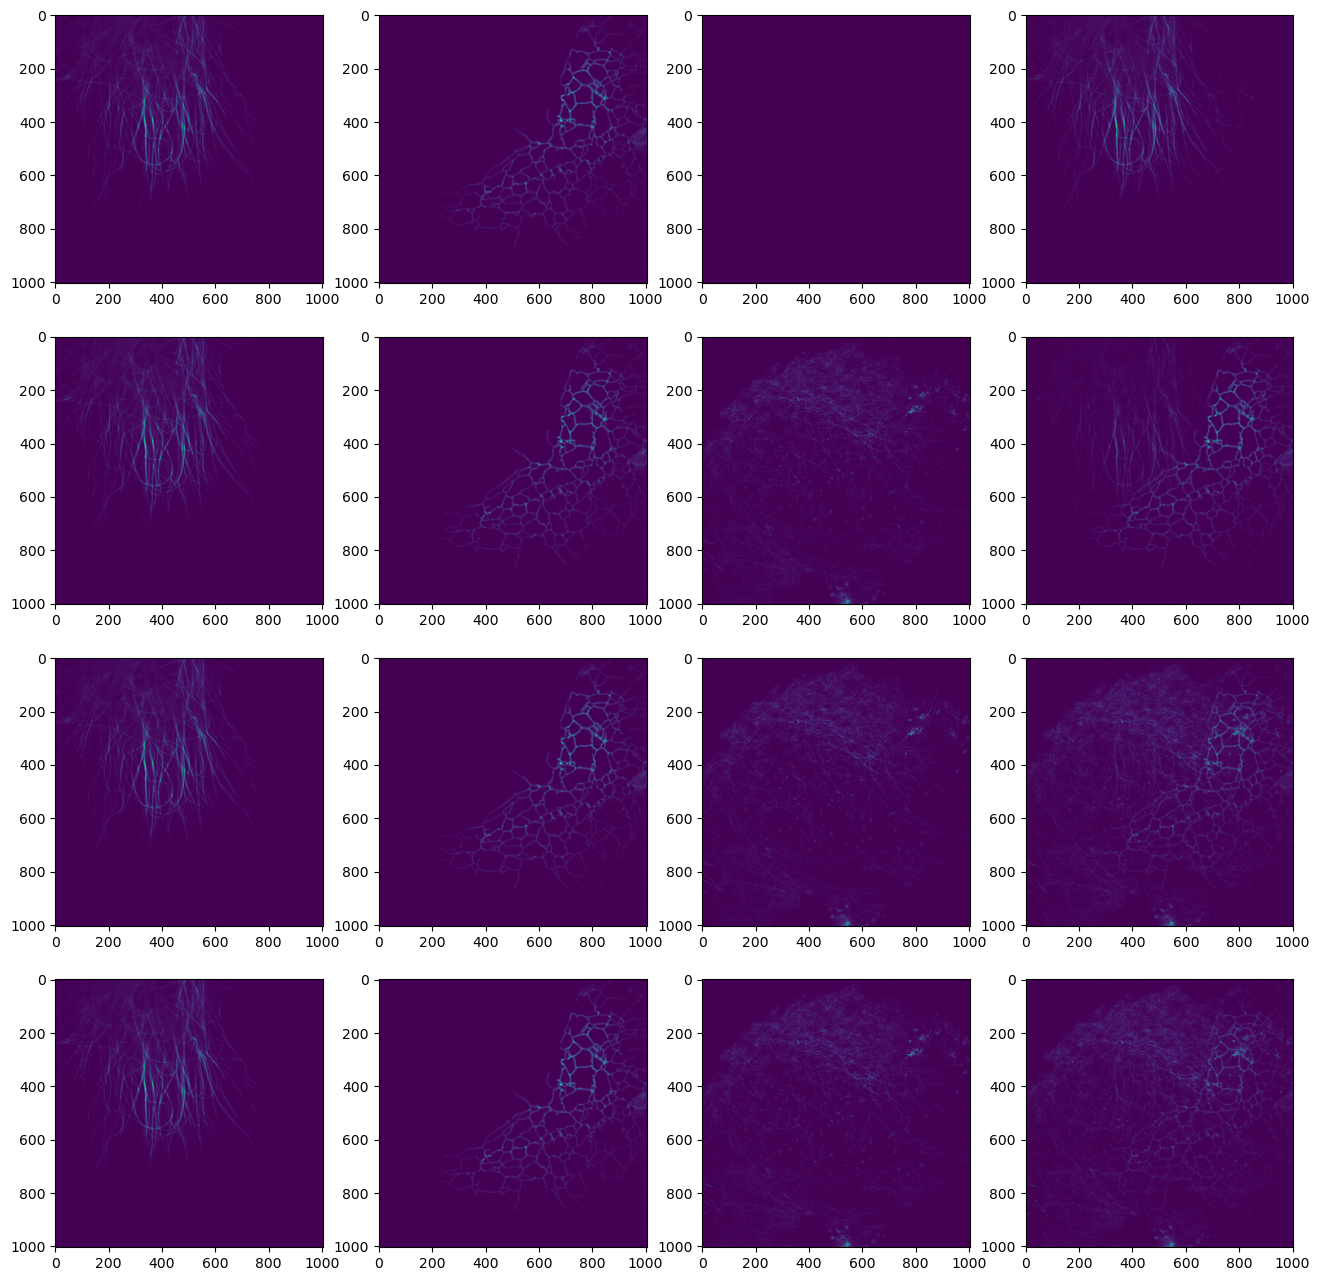

In [13]:
em_img, _, _ = sim.spectral_emission_flux(gt, channel_idx=0)
print(em_img.sizes) # (W, C, F+1, Z, Y, X)

sp_bands_idxs = [4, 12, 20, 28]
_, ax = plt.subplots(len(sp_bands_idxs), em_img.shape[2], figsize=(16, 16))
for i, num in enumerate(sp_bands_idxs):
    for j in range(em_img.shape[2]):
        ax[i, j].imshow(em_img[num, 0, j, 0, ...])

Obtaining optical image for fluorophore 0...


Convolving PSF over spectral bands: 100%|██████████| 32/32 [00:00<00:00, 37.07it/s]


Obtaining optical image for fluorophore 1...


Convolving PSF over spectral bands: 100%|██████████| 32/32 [00:00<00:00, 36.36it/s]


Obtaining optical image for fluorophore 2...


Convolving PSF over spectral bands: 100%|██████████| 32/32 [00:00<00:00, 36.80it/s]


Obtaining optical image for fluorophore 3...


Convolving PSF over spectral bands: 100%|██████████| 32/32 [00:00<00:00, 37.32it/s]


(32, 1, 4, 1, 1004, 1004) Coordinates:
  * w        (w) object 256B (460.0, 463.0] (463.0, 466.0] ... (548.0, 549.0]
  * c        (c) object 8B name='FEDERICO' filters=[SpectrumFilter(type='spec...
  * f        (f) object 32B distribution=BioSR(root_dir='/group/jug/federico/...
  * z        (z) float64 8B 0.0
  * y        (y) float64 8kB 0.0 0.02 0.04 0.06 0.08 ... 20.0 20.02 20.04 20.06
  * x        (x) float64 8kB 0.0 0.02 0.04 0.06 0.08 ... 20.0 20.02 20.04 20.06


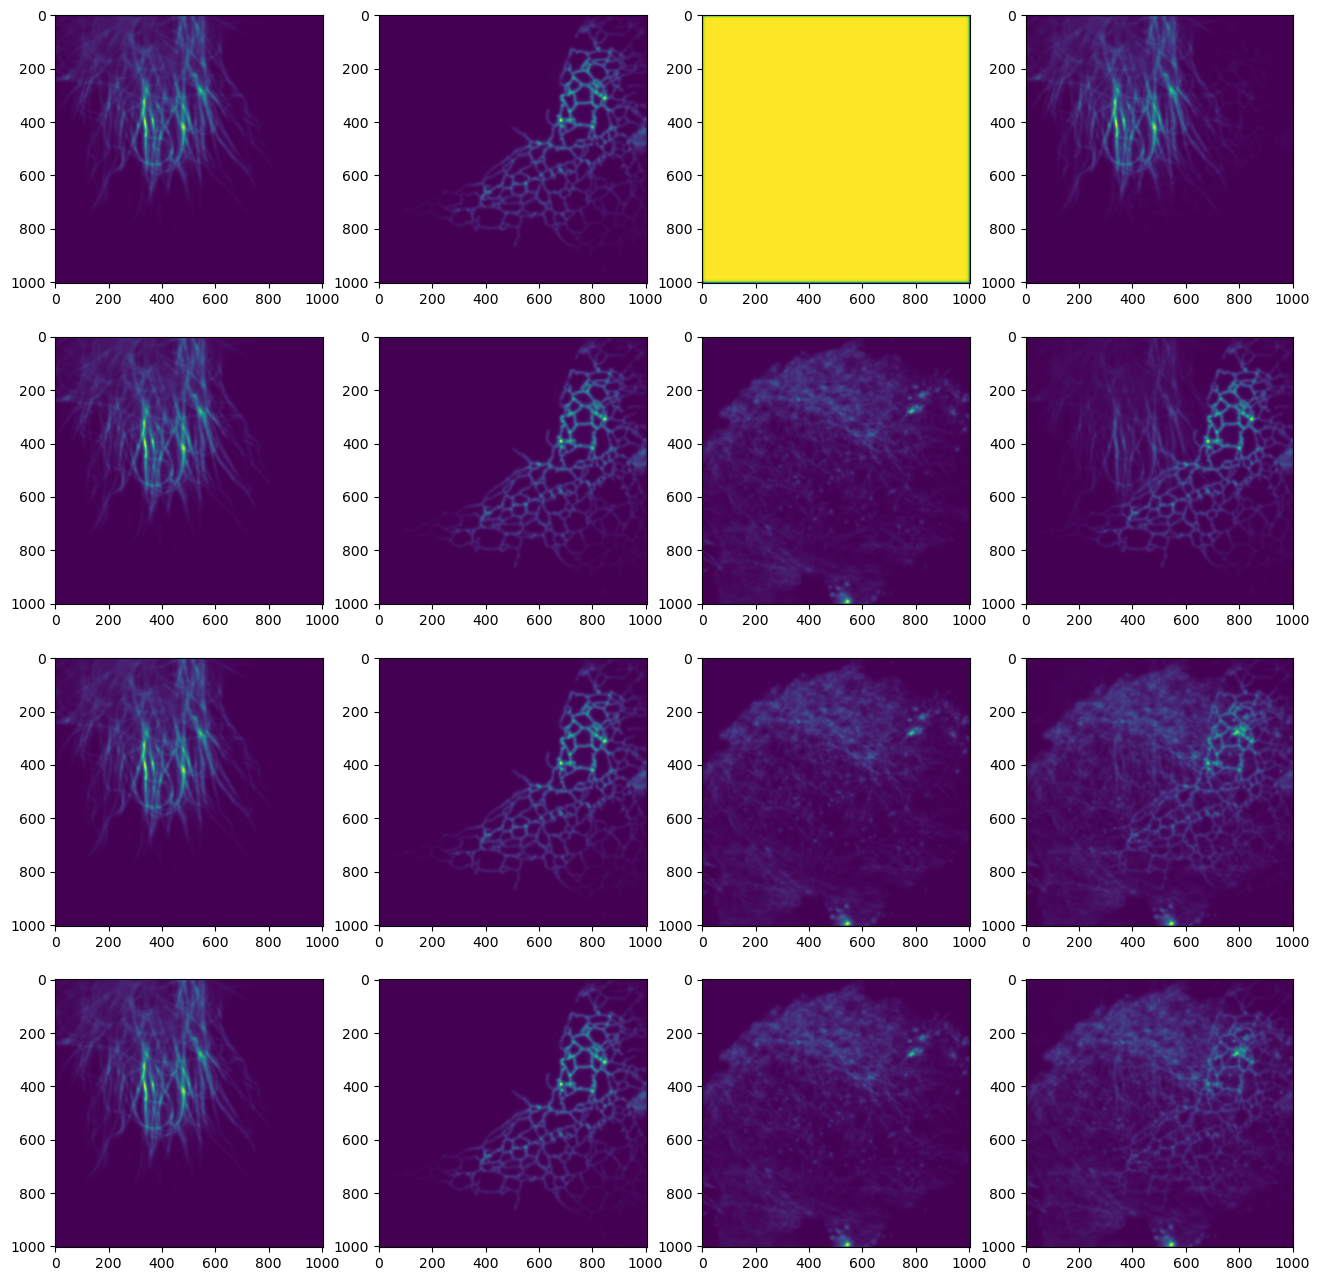

In [14]:
sim.spectral_image = True
opt_img = sim.optical_image(em_img, channel_idx=0)
print(opt_img.sizes) # (W, C, F+1, Z, Y, X)

sp_bands_idxs = [4, 12, 20, 28]
_, ax = plt.subplots(len(sp_bands_idxs), opt_img.shape[2], figsize=(16, 16))
for i, num in enumerate(sp_bands_idxs):
    for j in range(opt_img.shape[2]):
        ax[i, j].imshow(opt_img[num, 0, j, 0, ...])

Frozen({<Axis.W>: 32, <Axis.C>: 1, <Axis.F>: 4, <Axis.Z>: 1, <Axis.Y>: 251, <Axis.X>: 251})


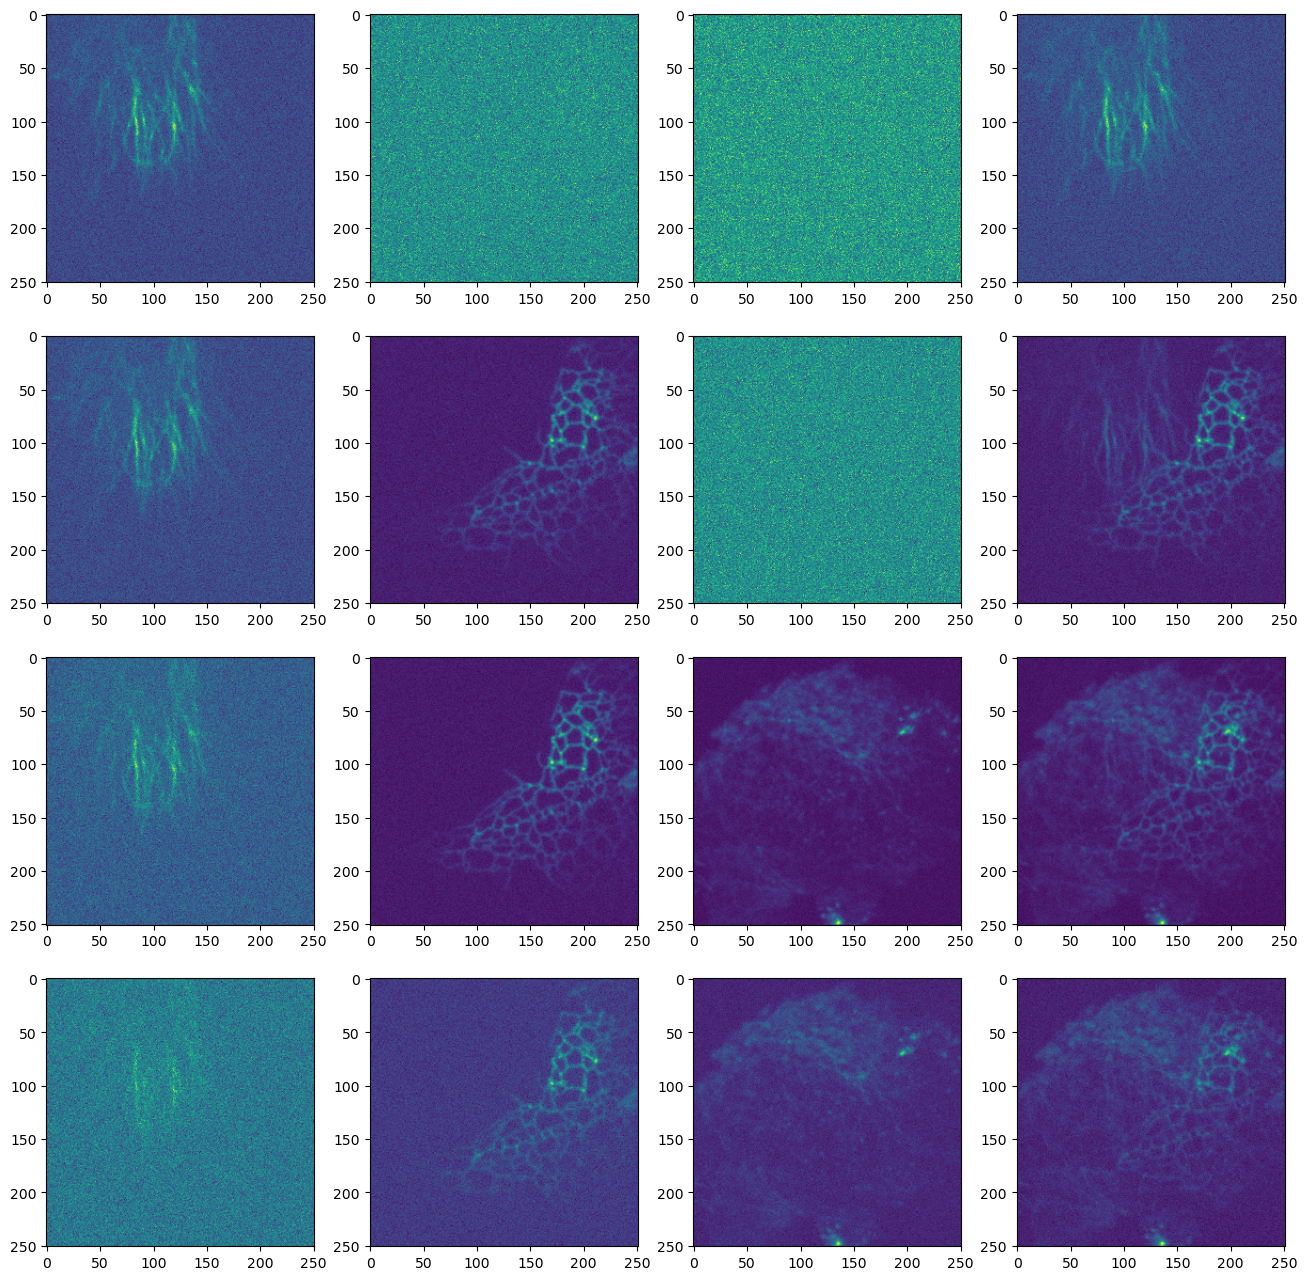

In [19]:
exposure = 100
digital_img = sim.digital_image(opt_img, exposure_ms=exposure)
print(digital_img.sizes) # (W, C, F+1, Z, Y, X)

sp_bands_idxs = [4, 12, 20, 28]
_, ax = plt.subplots(len(sp_bands_idxs), digital_img.shape[2], figsize=(16, 16))
for i, num in enumerate(sp_bands_idxs):
    for j in range(digital_img.shape[2]):
        ax[i, j].imshow(digital_img[num, 0, j, 0, ...])